# DEVELOPING A FLIGHT DELAY PREDICTION MODEL USING MACHINE LEARNNG


# Data Preprocessing

In [1]:
# importing the required libraries
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore')

# Importing Data

In [2]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='G4PbGkT7du7Tqx9ZD8c_FFVQze5z4I0AVFuw1fjQVM4N',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'flightdelayprediction-donotdelete-pr-3hqw5q6qtfh1ys'
object_key = 'flightdata.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset = pd.read_csv(body)
dataset.head()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


# Analysing the data

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11231 entries, 0 to 11230
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 11231 non-null  int64  
 1   QUARTER              11231 non-null  int64  
 2   MONTH                11231 non-null  int64  
 3   DAY_OF_MONTH         11231 non-null  int64  
 4   DAY_OF_WEEK          11231 non-null  int64  
 5   UNIQUE_CARRIER       11231 non-null  object 
 6   TAIL_NUM             11231 non-null  object 
 7   FL_NUM               11231 non-null  int64  
 8   ORIGIN_AIRPORT_ID    11231 non-null  int64  
 9   ORIGIN               11231 non-null  object 
 10  DEST_AIRPORT_ID      11231 non-null  int64  
 11  DEST                 11231 non-null  object 
 12  CRS_DEP_TIME         11231 non-null  int64  
 13  DEP_TIME             11124 non-null  float64
 14  DEP_DELAY            11124 non-null  float64
 15  DEP_DEL15            11124 non-null 

In [4]:
dataset.describe()


,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_NUM,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,DEP_TIME,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
count,11231.0,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11124.000000,...,11231.000000,11116.000000,11043.000000,11043.000000,11231.000000,11231.000000,11231.000000,11043.000000,11231.000000,0.0
mean,2016.0,2.544475,6.628973,15.790758,3.960199,1334.325617,12334.516695,12302.274508,1320.798326,1327.189410,...,1537.312795,1523.978499,-2.573123,0.124513,0.010150,0.006589,190.652124,179.661233,1161.031965,NaN
std,0.0,1.090701,3.354678,8.782056,1.995257,811.875227,1595.026510,1601.988550,490.737845,500.306462,...,502.512494,512.536041,39.232521,0.330181,0.100241,0.080908,78.386317,77.940399,643.683379,NaN
min,2016.0,1.000000,1.000000,1.000000,1.000000,7.000000,10397.000000,10397.000000,10.000000,1.000000,...,2.000000,1.000000,-67.000000,0.000000,0.000000,0.000000,93.000000,75.000000,509.000000,NaN
25%,2016.0,2.000000,4.000000,8.000000,2.000000,624.000000,10397.000000,10397.000000,905.000000,905.000000,...,1130.000000,1135.000000,-19.000000,0.000000,0.000000,0.000000,127.000000,117.000000,594.000000,NaN
50%,2016.0,3.000000,7.000000,16.000000,4.000000,1267.000000,12478.000000,12478.000000,1320.000000,1324.000000,...,1559.000000,1547.000000,-10.000000,0.000000,0.000000,0.000000,159.000000,149.000000,907.000000,NaN
75%,2016.0,3.000000,9.000000,23.000000,6.000000,2032.000000,13487.000000,13487.000000,1735.000000,1739.000000,...,1952.000000,1945.000000,1.000000,0.000000,0.000000,0.000000,255.000000,236.000000,1927.000000,NaN
max,2016.0,4.000000,12.000000,31.000000,7.000000,2853.000000,14747.000000,14747.000000,2359.000000,2400.000000,...,2359.000000,2400.000000,615.000000,1.000000,1.000000,1.000000,397.000000,428.000000,2422.000000,NaN


# Handling missing values

In [5]:
dataset.isnull().sum()

YEAR                       0
QUARTER                    0
MONTH                      0
DAY_OF_MONTH               0
DAY_OF_WEEK                0
UNIQUE_CARRIER             0
TAIL_NUM                   0
FL_NUM                     0
ORIGIN_AIRPORT_ID          0
ORIGIN                     0
DEST_AIRPORT_ID            0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                 107
DEP_DELAY                107
DEP_DEL15                107
CRS_ARR_TIME               0
ARR_TIME                 115
ARR_DELAY                188
ARR_DEL15                188
CANCELLED                  0
DIVERTED                   0
CRS_ELAPSED_TIME           0
ACTUAL_ELAPSED_TIME      188
DISTANCE                   0
Unnamed: 25            11231
dtype: int64

In [6]:
dataset['DEST'].unique()


array(['SEA', 'MSP', 'DTW', 'ATL', 'JFK'], dtype=object)

<AxesSubplot:xlabel='ARR_DELAY', ylabel='ARR_DEL15'>

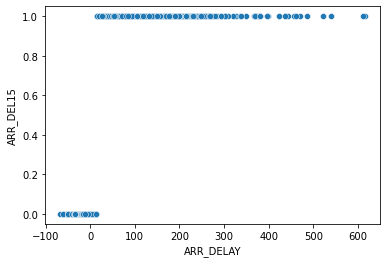

In [7]:
# Data visualization
sns.scatterplot(dataset['ARR_DELAY'],dataset['ARR_DEL15'])



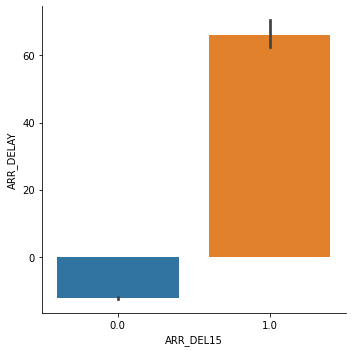

In [8]:
sns.catplot(x="ARR_DEL15",y="ARR_DELAY",kind='bar',data=dataset)


<AxesSubplot:>

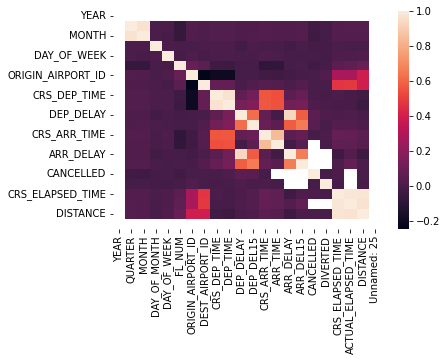

In [9]:
sns.heatmap(dataset.corr())


# Dropping unnecessary columns


In [10]:
dataset = dataset.drop('Unnamed: 25',axis=1)
dataset.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

In [11]:
dataset = dataset[["FL_NUM","MONTH","DAY_OF_MONTH","DAY_OF_WEEK","ORIGIN","DEST","CRS_ARR_TIME","DEP_DEL15","ARR_DEL15"]]
dataset.isnull().sum()

FL_NUM            0
MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_ARR_TIME      0
DEP_DEL15       107
ARR_DEL15       188
dtype: int64

In [12]:
# replace missing values with 0 and 1 
dataset = dataset.fillna({'ARR_DEL15':1})
dataset = dataset.fillna({'DEP_DEL15':0})
dataset.iloc[177:185]

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
177,2834,1,9,6,MSP,SEA,852,0.0,1.0
178,2839,1,9,6,DTW,JFK,1724,0.0,0.0
179,86,1,10,7,MSP,DTW,1632,0.0,1.0
180,87,1,10,7,DTW,MSP,1649,1.0,0.0
181,423,1,10,7,JFK,ATL,1600,0.0,0.0
182,440,1,10,7,JFK,ATL,849,0.0,0.0
183,485,1,10,7,JFK,SEA,1945,1.0,0.0
184,557,1,10,7,MSP,DTW,912,0.0,1.0


In [13]:
#count no of values with respect to unique values of each columns
for i in dataset.columns:
    print(dataset[i].value_counts())

888     98
589     96
1991    96
588     95
902     94
        ..
2849     1
1531     1
1493     1
1507     1
2640     1
Name: FL_NUM, Length: 690, dtype: int64
8     1127
7     1078
6      979
9      962
10     955
5      916
12     899
11     891
3      885
4      882
1      860
2      797
Name: MONTH, dtype: int64
8     390
23    381
28    379
11    378
14    378
21    378
22    376
26    375
18    373
9     372
2     371
10    370
15    370
12    369
19    368
27    368
5     366
17    366
16    365
24    363
1     363
13    362
20    362
29    361
25    360
4     360
6     357
7     355
3     351
30    335
31    209
Name: DAY_OF_MONTH, dtype: int64
5    1668
1    1652
4    1637
3    1624
2    1607
7    1593
6    1450
Name: DAY_OF_WEEK, dtype: int64
ATL    3100
MSP    2538
DTW    2201
SEA    2018
JFK    1374
Name: ORIGIN, dtype: int64
ATL    3221
MSP    2493
DTW    2211
SEA    1994
JFK    1312
Name: DEST, dtype: int64
1655    81
1840    72
1945    64
1345    54
1051    54
        .

In [14]:
dataset.head(5)


,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
0,1399,1,1,5,ATL,SEA,2143,0.0,0.0
1,1476,1,1,5,DTW,MSP,1435,0.0,0.0
2,1597,1,1,5,ATL,SEA,1215,0.0,0.0
3,1768,1,1,5,SEA,MSP,1335,0.0,0.0
4,1823,1,1,5,SEA,DTW,607,0.0,0.0


In [15]:
dataset.duplicated().sum()


0

In [16]:
dataset.iloc[179,:].isnull(),dataset.iloc[179,:]


(FL_NUM          False
 MONTH           False
 DAY_OF_MONTH    False
 DAY_OF_WEEK     False
 ORIGIN          False
 DEST            False
 CRS_ARR_TIME    False
 DEP_DEL15       False
 ARR_DEL15       False
 Name: 179, dtype: bool,
 FL_NUM            86
 MONTH              1
 DAY_OF_MONTH      10
 DAY_OF_WEEK        7
 ORIGIN           MSP
 DEST             DTW
 CRS_ARR_TIME    1632
 DEP_DEL15        0.0
 ARR_DEL15        1.0
 Name: 179, dtype: object)

In [17]:
dataset[(dataset["DEP_DEL15"]==0)&(dataset["ARR_DEL15"]==1)]


,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
34,1770,1,4,1,SEA,MSP,2032,0.0,1.0
128,744,1,7,4,MSP,ATL,1334,0.0,1.0
146,8,1,8,5,MSP,ATL,2105,0.0,1.0
166,1473,1,8,5,SEA,JFK,1930,0.0,1.0
167,1598,1,8,5,SEA,ATL,1401,0.0,1.0
...,...,...,...,...,...,...,...,...,...
11120,811,12,29,4,ATL,MSP,1532,0.0,1.0
11168,984,12,30,5,ATL,JFK,2315,0.0,1.0
11173,2610,12,31,6,ATL,MSP,900,0.0,1.0
11187,95,12,3,6,ATL,DTW,1436,0.0,1.0


In [18]:
dataset.describe()


,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15
count,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000,11231.000000
mean,1334.325617,6.628973,15.790758,3.960199,1537.312795,0.141483,0.139168
std,811.875227,3.354678,8.782056,1.995257,502.512494,0.348535,0.346138
min,7.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000
25%,624.000000,4.000000,8.000000,2.000000,1130.000000,0.000000,0.000000
50%,1267.000000,7.000000,16.000000,4.000000,1559.000000,0.000000,0.000000
75%,2032.000000,9.000000,23.000000,6.000000,1952.000000,0.000000,0.000000
max,2853.000000,12.000000,31.000000,7.000000,2359.000000,1.000000,1.000000


In [19]:
oh = OneHotEncoder()
z = oh.fit_transform(dataset[['ORIGIN','DEST']]).toarray()
t = oh.fit_transform(dataset[['DEST','CRS_ARR_TIME']]).toarray()

In [20]:
z

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [21]:
t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [22]:
#Splitting into dependent and independent variables
dataset = pd.get_dummies(dataset , columns=['ORIGIN','DEST'])
dataset.head()

,FL_NUM,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ARR_TIME,DEP_DEL15,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1399,1,1,5,2143,0.0,0.0,1,0,0,0,0,0,0,0,0,1
1,1476,1,1,5,1435,0.0,0.0,0,1,0,0,0,0,0,0,1,0
2,1597,1,1,5,1215,0.0,0.0,1,0,0,0,0,0,0,0,0,1
3,1768,1,1,5,1335,0.0,0.0,0,0,0,0,1,0,0,0,1,0
4,1823,1,1,5,607,0.0,0.0,0,0,0,0,1,0,1,0,0,0


In [23]:
x=dataset.drop(columns=['ARR_DEL15']).values

y=dataset['ARR_DEL15'].values

# Splitting into train and test data

In [24]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [25]:
x_test.shape

(2247, 16)

In [26]:
x_train.shape

(8984, 16)

In [27]:
y_test.shape

(2247,)

In [28]:
y_train.shape

(8984,)

# MODEL BUILDING

# DecisionTree

In [29]:

from sklearn.tree import DecisionTreeClassifier
dc=DecisionTreeClassifier()
dc.fit(x_train,y_train)
dc.score(x_test,y_test)

0.8753894080996885

# RandomForest

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=50,random_state=42)
rf.fit(x_train,y_train)
rf.score(x_test,y_test)

0.9101023587004895

In [31]:
pd.DataFrame(rf.predict(x_test)).value_counts()

0.0    2010
1.0     237
dtype: int64

# LogisticRegression

In [32]:
from sklearn.linear_model import LogisticRegression
lr1=LogisticRegression(solver='sag')
lr1.fit(x_train,y_train)
lr1.score(x_test,y_test)

0.8615932354250111

In [33]:
lr1.predict(x_test).sum()

0.0

# SVM

In [34]:
from sklearn.svm import SVC
svm=SVC(kernel='sigmoid')
svm.fit(x_train,y_train)
svm.score(x_test,y_test)

0.7739207832665776

In [35]:
pd.DataFrame(svm.predict(x_test)).value_counts()


0.0    1948
1.0     299
dtype: int64

In [36]:
pd.DataFrame(y_test).value_counts()


0.0    1936
1.0     311
dtype: int64

# KNearestNeighbourClassifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.8531375166889186

In [38]:
pd.DataFrame(knn.predict(x_test)).value_counts()

0.0    2158
1.0      89
dtype: int64

# Evaluation Of Random Forest

Testing Sensitivity for Random Forest 0.9313432835820895
Testing Specificity for Random Forest 0.729957805907173
Testing Precision for Random Forest 0.9669421487603306
Testing accuracy for Random Forest 0.9101023587004895


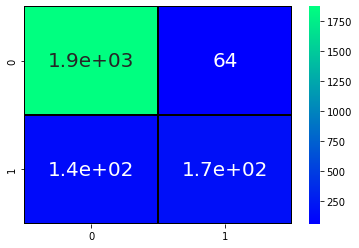

In [39]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
pred=rf.predict(x_test)
cm=confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True,cmap='winter',linewidths=0.3, linecolor='black',annot_kws={"size": 20})
TP=cm[0][0]
TN=cm[1][1]
FN=cm[1][0]
FP=cm[0][1]
#print(round(accuracy_score(prediction3,y_test)*100,2))
#print('Testing Accuracy for knn',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Random Forest',(TP/(TP+FN)))
print('Testing Specificity for Random Forest',(TN/(TN+FP)))
print('Testing Precision for Random Forest',(TP/(TP+FP)))
print('Testing accuracy for Random Forest',accuracy_score(y_test, pred))

In [40]:
print(classification_report(y_test,pred))#RandomForest

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1936
         1.0       0.73      0.56      0.63       311

    accuracy                           0.91      2247
   macro avg       0.83      0.76      0.79      2247
weighted avg       0.90      0.91      0.90      2247



# Evaluation Of Decission Tree

Testing Accuracy for Decision Tree 0.8753894080996885
Testing Sensitivity for Decision Tree 0.9299065420560748
Testing Specificity for Decision Tree 0.5482866043613707
Testing Precision for Decision Tree 0.925103305785124
Testing accuracy for Decision Tree 0.8753894080996885


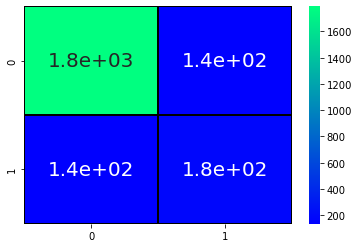

In [42]:
pred1=dc.predict(x_test)
cm1=confusion_matrix(y_test, pred1)
sns.heatmap(cm1, annot=True,cmap='winter',linewidths=0.3, linecolor='black',annot_kws={"size": 20})
TP=cm1[0][0]
TN=cm1[1][1]
FN=cm1[1][0]
FP=cm1[0][1]
#print(round(accuracy_score(prediction3,y_test)*100,2))
print('Testing Accuracy for Decision Tree',(TP+TN)/(TP+TN+FN+FP))
print('Testing Sensitivity for Decision Tree',(TP/(TP+FN)))
print('Testing Specificity for Decision Tree',(TN/(TN+FP)))
print('Testing Precision for Decision Tree',(TP/(TP+FP)))
print('Testing accuracy for Decision Tree',accuracy_score(y_test, pred1))

In [43]:
print(classification_report(y_test,pred1))


              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1936
         1.0       0.55      0.57      0.56       311

    accuracy                           0.88      2247
   macro avg       0.74      0.75      0.74      2247
weighted avg       0.88      0.88      0.88      2247



In [44]:
import pickle


In [45]:
pickle.dump(rf,open("rfmodel.pkl",'wb'))


In [46]:
import sklearn
sklearn.__version__

'1.0.2'

In [47]:
!pip install -U ibm-watson-machine-learning

In [51]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "B_EVqatLl8m6PwfFYDpCpevQdnFSa0_NrmyPks-lUcUY"
}
client = APIClient(wml_credentials)

In [52]:
def guid_from_space_name(client, space_name):
    space = wml_client.spaces.get_details()
    #print(space)
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [53]:
space_uid = guid_from_space_name(client, 'space')
print("Space UID = " + space_uid)


Space UID = a8bfc874-2391-4d38-bf7d-3d9d2a37b9cd


In [54]:
client.set.default_space(space_uid)

'SUCCESS'

In [55]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [56]:
software_spec_uid = wml_client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [58]:
model_details = client.repository.store_model(model=rf,meta_props={
client.repository.ModelMetaNames.NAME: 'flightdelay',
client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid}
                                             )
model_id = client.repository.get_model_id(model_details)

In [59]:
model_id

'7aaa81a8-e0f7-4648-a9ab-28e4ea16796c'